In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('./csv/housing.csv')

In [5]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


# 入力変数と教師データに分割

In [6]:
x = df.iloc[:, :-1].values.astype('f')
t = df.iloc[:, -1].values.astype('f')

In [7]:
x.shape

(506, 13)

In [8]:
t.shape

(506,)

In [9]:
len(t)

506

In [10]:
t = t.reshape(len(t), 1)

In [11]:
t.shape

(506, 1)

# データセットの準備

In [12]:
dataset = list(zip(x, t))

# 訓練データと検証データの分割

In [13]:
import chainer
import chainer.functions as F
import chainer.links as L

In [14]:
n_train = int(len(dataset) * 0.7)
n_train

354

In [15]:
train, test = chainer.datasets.split_dataset_random(dataset, n_train, seed=0)

In [16]:
len(train)

354

In [17]:
len(test)

152

# モデルの定義

# L.Classifierを使う場合

In [18]:
# 13 -> 5 -> 1
class NN(chainer.Chain):
    # モデルの構造
    def __init__(self, n_mid_units=5, n_out=1):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)
            self.fc2 = L.Linear(None, n_out)
            
            # Batch Nomalization
            self.bn = L.BatchNormalization(13)
    
    # 順伝播
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [19]:
np.random.seed(0)
# インスタンス化
nn = NN()

In [20]:
# 変更箇所
model = L.Classifier(nn, lossfun=F.mean_squared_error)
model.compute_accuracy = False

# 学習用のモデルを自前で書く場合

In [21]:
# # 13 -> 5 -> 1
# class NN(chainer.Chain):
#     # モデルの構造
#     def __init__(self, n_mid_units=5, n_out=1):
#         super().__init__()
#         with self.init_scope():
#             self.fc1 = L.Linear(None, n_mid_units)
#             self.fc2 = L.Linear(None, n_out)
    
#     # 損失関数の計算
#     def __call__(self, x, t):
#         # 予測値の計算(順伝播)
#         y = self.predictor(x)
#         loss = F.mean_squared_error(t, y)
#         chainer.report({'loss': loss}, self)
#         return loss
    
#     # 順伝播
#     def predictor(self, x):
#         h = self.fc1(x)
#         h = F.relu(h)
#         h = self.fc2(h)
#         return h

In [22]:
# np.random.seed(0)
# model = NN()

# 学習に必要な準備

In [23]:
#optimizer = chainer.optimizers.SGD() # 確率的勾配降下法
optimizer = chainer.optimizers.Adam() # 確率的勾配降下法

optimizer.setup(model)

batchsize = 10

train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

from chainer import training
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

from chainer.training import extensions

# エポックの数
epoch = 500

# trainerの宣言
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/housing')

# 検証データで評価
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))

trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
# 1 エポックごとにtrainデータに対するloss/accuracyとtestデータに対するloss/accuracy, 経過時間を出力
trainer.extend(extensions.PrintReport(['epoch',
                                       'main/loss',
                                       'validation/main/loss',
                                       'elapsed_time']),
                                       trigger=(1, 'epoch'))

# 学習の実行

In [24]:
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           575.005     603.083               0.0562497     
2           558.217     591.554               0.125739      
3           548.793     574.242               0.186931      
4           521.226     547.619               0.248102      
5           504.153     507.164               0.303774      
6           462.463     468.416               0.360943      
7           408.87      413.969               0.416918      
8           366.207     357.926               0.474778      
9           293.685     257.43                0.531434      
10          241.922     227.014               0.589342      
11          192.413     178.442               0.652245      
12          154.55      143.469               0.710743      
13          118.269     114.239               0.769656      
14          99.1176     100.104               0.826618      
15          85.8353     81.4782               0.890331      
16          70.8336     71

In [25]:
# 結果の確認
import json
with open('result/housing/log') as f:
    logs = json.load(f)
    results = pd.DataFrame(logs)
results.tail()

,main/loss,validation/main/loss,epoch,iteration,elapsed_time
495,26.219645,13.089479,496,17559,34.813615
496,23.044174,13.623697,497,17594,34.883480
497,22.879997,12.362228,498,17630,34.961159
498,21.000424,15.713933,499,17665,35.036108
499,24.678652,13.430212,500,17700,35.107034


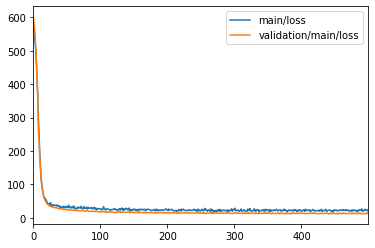

In [26]:
results[['main/loss', 'validation/main/loss']].plot()

In [27]:
loss = results[['validation/main/loss']].values[-1]
loss

array([13.43021232])

In [28]:
import math

In [29]:
math.sqrt(loss)

3.6647254083897263

In [30]:
df.head() # ばらつきがある

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
